In [ ]:
#|default_exp tslearner

# TSLearner

New set of time series learners with a new sklearn-like API that simplifies the learner creation. The following classes are included: 

  * TSClassifier
  * TSRegressor
  * TSForecaster

In [ ]:
#|export
from fastai.learner import Learner
from fastai.optimizer import Adam
from fastai.metrics import accuracy
from fastai.losses import *
from tsai.imports import *
from tsai.learner import *
from tsai.data.validation import *
from tsai.data.core import *
from tsai.models.InceptionTimePlus import *
from tsai.models.utils import *
from tsai.metrics import *

## TSClassifier API
***

**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps) with the input time series samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs) with the target. Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 100:0 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default:None.
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **pipelines:** store sklearn-type pipelines that can then be applied to pandas dataframes with transform or inverse_transform methods. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Alternatively, you can pass an instantiated model. Default: InceptionTimePlus.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=accuracy.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **s_cat_idxs:** list of indices for static categorical variables
* **s_cat_embeddings:** list of num_embeddings for each static categorical variable
* **s_cat_embedding_dims:** list of embedding dimensions for each static categorical variable
* **s_cont_idxs:** list of indices for static continuous variables
* **o_cat_idxs:** list of indices for observed categorical variables
* **o_cat_embeddings:** list of num_embeddings for each observed categorical variable
* **o_cat_embedding_dims:** list of embedding dimensions for each observed categorical variable
* **o_cont_idxs:** list of indices for observed continuous variables
* **patch_len:** Number of time steps in each patch.
* **patch_stride:** Stride of the patch.
* **fusion_layers:** list of layer dimensions for the fusion MLP
* **fusion_act:** activation function for the fusion MLP
* **fusion_dropout:** dropout probability for the fusion MLP
* **fusion_use_bn:** boolean indicating whether to use batch normalization in the fusion MLP
* **weights:** indicates a sample weight per instance. Used to pass pass a probability to the train dataloader sampler. Samples with more weight will be selected more often during training. 
* **partial_n:** select randomly partial quantity of data at each epoch. Used to reduce the training size (for example for testing purposes). int or float can be used.
* **vocab:** vocabulary used to transform the target. Only required when transformed is not perform by a dataloader's tfm (external transforms).
* **train_metrics:** flag used to display metrics in the training set. Defaults to False.
* **valid_metrics:** flag used to display metrics in the validtion set. Defaults to True.
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training, but it can only be used when data fits in memory. Otherwise set it to False. 
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=0. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **seed:** Set to an int to ensure reprodubibility. Default=None.
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#|export
class TSClassifier(Learner):
    def __init__(self, X, y=None, splits=None, tfms=None, inplace=True, sel_vars=None, sel_steps=None,
                 s_cat_idxs=None, s_cat_embeddings=None, s_cat_embedding_dims=None, s_cont_idxs=None,
                 o_cat_idxs=None, o_cat_embeddings=None, o_cat_embedding_dims=None, o_cont_idxs=None,
                 patch_len=None, patch_stride=None, fusion_layers=128, fusion_act='relu', fusion_dropout=0., fusion_use_bn=True,
                 weights=None, partial_n=None, vocab=None,
                 train_metrics=False, valid_metrics=True, bs=[64, 128], batch_size=None, batch_tfms=None, pipelines=None,
                 shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None, seed=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=accuracy, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        # Seed
        if seed is not None:
            set_seed(seed, reproducible=True)

        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, vocab=vocab,
                         path=path, bs=bs, batch_tfms=batch_tfms, num_workers=num_workers, weights=weights, partial_n=partial_n,
                         device=device, shuffle_train=shuffle_train, drop_last=drop_last)

        if loss_func is None:
            if hasattr(dls, 'loss_func'): loss_func = dls.loss_func
            elif hasattr(dls, 'cat') and not dls.cat: loss_func = MSELossFlat()
            elif hasattr(dls, 'train_ds') and hasattr(dls.train_ds, 'loss_func'): loss_func = dls.train_ds.loss_func
            else: loss_func = CrossEntropyLossFlat()

        # Model
        if isinstance(arch, nn.Module):
            model = arch
            if arch_config:
                warnings.warn("You have passed arch_config to a model that is already intantiated. It will not have any effect.", UserWarning)
            if init is not None:
                warnings.warn("You have passed init to a model that is already intantiated. It will not have any effect.", UserWarning)
        else:
            if init is True:
                init = nn.init.kaiming_normal_
            if arch is None:
                arch = InceptionTimePlus
            elif isinstance(arch, str): arch = get_arch(arch)
            # if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            #     model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, arch_config=arch_config)
            # elif 'tabularmodel' in arch.__name__.lower():
            #     model = build_tabular_model(arch, dls=dls, device=device, arch_config=arch_config)
            # else:
            #     model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
            #                            exclude_head=exclude_head, cut=cut, init=init, arch_config=arch_config)
            model = build_ts_model(arch, dls=dls,
                                   s_cat_idxs=s_cat_idxs, s_cat_embeddings=s_cat_embeddings, s_cat_embedding_dims=s_cat_embedding_dims, s_cont_idxs=s_cont_idxs,
                                   o_cat_idxs=o_cat_idxs, o_cat_embeddings=o_cat_embeddings, o_cat_embedding_dims=o_cat_embedding_dims, o_cont_idxs=o_cont_idxs,
                                   patch_len=patch_len, patch_stride=patch_stride,
                                   fusion_layers=fusion_layers, fusion_act=fusion_act, fusion_dropout=fusion_dropout, fusion_use_bn=fusion_use_bn,
                                   device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                                   exclude_head=exclude_head, cut=cut, init=init, arch_config=arch_config)
        try:
            setattr(model, "__name__", arch.__name__)
        except:
            setattr(model, "__name__", arch.__class__.__name__)

        if hasattr(model, "backbone") and hasattr(model, "head"):
            splitter = ts_splitter

        if pipelines is not None:
            pipelines = listify(pipelines)
        setattr(self, "pipelines", pipelines)

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

        if hasattr(self, "recorder"):
            self.recorder.train_metrics = train_metrics
            if splits is None or not hasattr(splits[0], "__len__") or len(splits) == 1 or \
                (len(splits) >= 2 and (splits[1] is None or not hasattr(splits[1], "__len__"))):
                self.recorder.valid_metrics = False
            else:
                self.recorder.valid_metrics = valid_metrics

In [ ]:
from tsai.data.external import *
from tsai.data.preprocessing import *
from tsai.models.InceptionTimePlus import *

In [ ]:
# With validation split
X, y, splits = get_classification_data('OliveOil', split_data=False)
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
learn = TSClassifier(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, arch=InceptionTimePlus, arch_config=dict(fc_dropout=.5),
                     train_metrics=True)
learn.fit_one_cycle(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.458827,0.300000,1.362652,0.300000,00:02


In [ ]:
# Without validation split
X, y, splits = get_classification_data('OliveOil', split_data=False)
splits = (splits[0], None)
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
learn = TSClassifier(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, arch=InceptionTimePlus, arch_config=dict(fc_dropout=.5),
                     train_metrics=True)
learn.fit_one_cycle(1)

epoch,train_loss,accuracy,time
0,1.457477,0.200000,00:01


In [ ]:
num_classes = 2
X = np.random.rand(16, 5, 128)
y = np.random.randint(0, num_classes, (16, 3))
splits = RandomSplitter()(range_of(X))
arch = 'TSiTPlus'
vocab = np.arange(num_classes)
learn = TSClassifier(X, y, splits=splits, arch=arch, metrics=accuracy, vocab=vocab, device=default_device())
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.749274,0.721294,0.666667,00:00


In [ ]:
num_classes = 5
X = torch.rand(8, 2, 50)
y = torch.randint(0, num_classes, (len(X), 7))
print(X.shape, y.shape)
splits = TimeSplitter(show_plot=False)(y)
vocab = np.arange(num_classes)

fail_test = []
for arch in all_arch_names:
    if not "plus" in arch.lower(): continue
    try:
        learn = TSClassifier(X, y, splits=splits, arch=arch, metrics=accuracy, vocab=vocab, device=default_device())
        with ContextManagers([learn.no_bar(), learn.no_logging()]):
            learn.fit_one_cycle(1, 1e-3)
        del learn
        gc.collect()
    except Exception as e:
        fail_test.append(arch)
        print(arch, e)

test_eq(fail_test, [])

torch.Size([8, 2, 50]) torch.Size([8, 7])


## TSRegressor API
***

**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps) with the input time series samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs) with the target. Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 100:0 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default=None.
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **pipelines:** store sklearn-type pipelines that can then be applied to pandas dataframes with transform or inverse_transform methods. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Alternatively, you can pass an instantiated model. Default: InceptionTimePlus.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=None.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **s_cat_idxs:** list of indices for static categorical variables
* **s_cat_embeddings:** list of num_embeddings for each static categorical variable
* **s_cat_embedding_dims:** list of embedding dimensions for each static categorical variable
* **s_cont_idxs:** list of indices for static continuous variables
* **o_cat_idxs:** list of indices for observed categorical variables
* **o_cat_embeddings:** list of num_embeddings for each observed categorical variable
* **o_cat_embedding_dims:** list of embedding dimensions for each observed categorical variable
* **o_cont_idxs:** list of indices for observed continuous variables
* **patch_len:** Number of time steps in each patch.
* **patch_stride:** Stride of the patch.
* **fusion_layers:** list of layer dimensions for the fusion MLP
* **fusion_act:** activation function for the fusion MLP
* **fusion_dropout:** dropout probability for the fusion MLP
* **fusion_use_bn:** boolean indicating whether to use batch normalization in the fusion MLP
* **weights:** indicates a sample weight per instance. Used to pass pass a probability to the train dataloader sampler. Samples with more weight will be selected more often during training. 
* **partial_n:** select randomly partial quantity of data at each epoch. Used to reduce the training size (for example for testing purposes). int or float can be used.
* **train_metrics:** flag used to display metrics in the training set. Defaults to False.
* **valid_metrics:** flag used to display metrics in the validtion set. Defaults to True.
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training, but it can only be used when data fits in memory. Otherwise set it to False. 
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=0. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **seed:** Set to an int to ensure reprodubibility. Default=None.
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#|export
class TSRegressor(Learner):
    def __init__(self, X, y=None, splits=None, tfms=None, inplace=True, sel_vars=None, sel_steps=None,
                 s_cat_idxs=None, s_cat_embeddings=None, s_cat_embedding_dims=None, s_cont_idxs=None,
                 o_cat_idxs=None, o_cat_embeddings=None, o_cat_embedding_dims=None, o_cont_idxs=None,
                 patch_len=None, patch_stride=None, fusion_layers=128, fusion_act='relu', fusion_dropout=0., fusion_use_bn=True,
                 weights=None, partial_n=None,
                 train_metrics=False, valid_metrics=True, bs=[64, 128], batch_size=None, batch_tfms=None, pipelines=None,
                 shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None, seed=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=None, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        # Seed
        if seed is not None:
            set_seed(seed, reproducible=True)


        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace,
                         path=path, bs=bs, batch_tfms=batch_tfms, num_workers=num_workers, weights=weights, partial_n=partial_n,
                         device=device, shuffle_train=shuffle_train, drop_last=drop_last)

        if loss_func is None:
            if hasattr(dls, 'loss_func'): loss_func = dls.loss_func
            elif hasattr(dls, 'cat') and not dls.cat: loss_func = MSELossFlat()
            elif hasattr(dls, 'train_ds') and hasattr(dls.train_ds, 'loss_func'): loss_func = dls.train_ds.loss_func
            else: loss_func = MSELossFlat()

        # Model
        if isinstance(arch, nn.Module):
            model = arch
            if arch_config:
                warnings.warn("You have passed arch_config to a model that is already intantiated. It will not have any effect.", UserWarning)
            if init is not None:
                warnings.warn("You have passed init to a model that is already intantiated. It will not have any effect.", UserWarning)
        else:
            if init is True:
                init = nn.init.kaiming_normal_
            if arch is None:
                arch = InceptionTimePlus
            elif isinstance(arch, str): arch = get_arch(arch)
            # if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            #     model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, arch_config=arch_config)
            # elif 'tabularmodel' in arch.__name__.lower():
            #     model = build_tabular_model(arch, dls=dls, device=device, arch_config=arch_config)
            # else:
            #     model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
            #                        exclude_head=exclude_head, cut=cut, init=init, arch_config=arch_config)
            model = build_ts_model(arch, dls=dls,
                                   s_cat_idxs=s_cat_idxs, s_cat_embeddings=s_cat_embeddings, s_cat_embedding_dims=s_cat_embedding_dims, s_cont_idxs=s_cont_idxs,
                                   o_cat_idxs=o_cat_idxs, o_cat_embeddings=o_cat_embeddings, o_cat_embedding_dims=o_cat_embedding_dims, o_cont_idxs=o_cont_idxs,
                                   patch_len=patch_len, patch_stride=patch_stride,
                                   fusion_layers=fusion_layers, fusion_act=fusion_act, fusion_dropout=fusion_dropout, fusion_use_bn=fusion_use_bn,
                                   device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                                   exclude_head=exclude_head, cut=cut, init=init, arch_config=arch_config)
        try:
            setattr(model, "__name__", arch.__name__)
        except:
            setattr(model, "__name__", arch.__class__.__name__)

        if hasattr(model, "backbone") and hasattr(model, "head"):
            splitter = ts_splitter

        if pipelines is not None:
            pipelines = listify(pipelines)
        setattr(self, "pipelines", pipelines)

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

        if hasattr(self, "recorder"):
            self.recorder.train_metrics = train_metrics
            if splits is None or not hasattr(splits[0], "__len__") or len(splits) == 1 or \
                (len(splits) >= 2 and (splits[1] is None or not hasattr(splits[1], "__len__"))):
                self.recorder.valid_metrics = False
            else:
                self.recorder.valid_metrics = valid_metrics

In [ ]:
X, y, splits = get_regression_data('AppliancesEnergy', split_data=False)
if X is not None: # This is to prevent a test fail when the data server is not available
    X = X.astype('float32')
    y = y.astype('float32')
    batch_tfms = [TSStandardize()]
    learn = TSRegressor(X, y, splits=splits, batch_tfms=batch_tfms, arch=None, metrics=mae, bs=512, train_metrics=True, device=default_device())
    learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,204.070648,13.636603,199.854218,13.712566,00:01


## TSForecaster API
***
**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps) with the input time series samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs) with the target. Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 100:0 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default=None.
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **pipelines:** store sklearn-type pipelines that can then be applied to pandas dataframes with transform or inverse_transform methods. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Alternatively, you can pass an instantiated model. Default: InceptionTimePlus.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=None.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **s_cat_idxs:** list of indices for static categorical variables
* **s_cat_embeddings:** list of num_embeddings for each static categorical variable
* **s_cat_embedding_dims:** list of embedding dimensions for each static categorical variable
* **s_cont_idxs:** list of indices for static continuous variables
* **o_cat_idxs:** list of indices for observed categorical variables
* **o_cat_embeddings:** list of num_embeddings for each observed categorical variable
* **o_cat_embedding_dims:** list of embedding dimensions for each observed categorical variable
* **o_cont_idxs:** list of indices for observed continuous variables
* **patch_len:** Number of time steps in each patch.
* **patch_stride:** Stride of the patch.
* **fusion_layers:** list of layer dimensions for the fusion MLP
* **fusion_act:** activation function for the fusion MLP
* **fusion_dropout:** dropout probability for the fusion MLP
* **fusion_use_bn:** boolean indicating whether to use batch normalization in the fusion MLP
* **weights:** indicates a sample weight per instance. Used to pass pass a probability to the train dataloader sampler. Samples with more weight will be selected more often during training. 
* **partial_n:** select randomly partial quantity of data at each epoch. Used to reduce the training size (for example for testing purposes). int or float can be used.
* **train_metrics:** flag used to display metrics in the training set. Defaults to False.
* **valid_metrics:** flag used to display metrics in the validtion set. Defaults to True.
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training, but it can only be used when data fits in memory. Otherwise set it to False. 
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=None. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **seed:** Set to an int to ensure reprodubibility. Default=None.
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#|export
class TSForecaster(Learner):
    def __init__(self, X, y=None, splits=None, tfms=None, inplace=True, sel_vars=None, sel_steps=None,
                 s_cat_idxs=None, s_cat_embeddings=None, s_cat_embedding_dims=None, s_cont_idxs=None,
                 o_cat_idxs=None, o_cat_embeddings=None, o_cat_embedding_dims=None, o_cont_idxs=None,
                 patch_len=None, patch_stride=None, fusion_layers=128, fusion_act='relu', fusion_dropout=0., fusion_use_bn=True,
                 weights=None, partial_n=None,
                 train_metrics=False, valid_metrics=True, bs=[64, 128], batch_size=None, batch_tfms=None, pipelines=None,
                 shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None, seed=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=None, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        # Seed
        if seed is not None:
            set_seed(seed, reproducible=True)

        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace,
                         path=path, bs=bs, batch_tfms=batch_tfms, num_workers=num_workers, weights=weights, partial_n=partial_n,
                         device=device, shuffle_train=shuffle_train, drop_last=drop_last)

        if loss_func is None:
            if hasattr(dls, 'loss_func'): loss_func = dls.loss_func
            elif hasattr(dls, 'cat') and not dls.cat: loss_func = MSELossFlat()
            elif hasattr(dls, 'train_ds') and hasattr(dls.train_ds, 'loss_func'): loss_func = dls.train_ds.loss_func
            else: loss_func = MSELossFlat()

        # Model
        if isinstance(arch, nn.Module):
            model = arch
            if arch_config:
                warnings.warn("You have passed arch_config to a model that is already intantiated. It will not have any effect.", UserWarning)
            if init is not None:
                warnings.warn("You have passed init to a model that is already intantiated. It will not have any effect.", UserWarning)
        else:
            if init is True:
                init = nn.init.kaiming_normal_
            if arch is None:
                arch = InceptionTimePlus
            elif isinstance(arch, str): arch = get_arch(arch)
            # if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            #     model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, arch_config=arch_config)
            # elif 'tabularmodel' in arch.__name__.lower():
            #     model = build_tabular_model(arch, dls=dls, device=device, arch_config=arch_config)
            # else:
            #     model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
            #                        exclude_head=exclude_head, cut=cut, init=init, arch_config=arch_config)
            model = build_ts_model(arch, dls=dls,
                                   s_cat_idxs=s_cat_idxs, s_cat_embeddings=s_cat_embeddings, s_cat_embedding_dims=s_cat_embedding_dims, s_cont_idxs=s_cont_idxs,
                                   o_cat_idxs=o_cat_idxs, o_cat_embeddings=o_cat_embeddings, o_cat_embedding_dims=o_cat_embedding_dims, o_cont_idxs=o_cont_idxs,
                                   patch_len=patch_len, patch_stride=patch_stride,
                                   fusion_layers=fusion_layers, fusion_act=fusion_act, fusion_dropout=fusion_dropout, fusion_use_bn=fusion_use_bn,
                                   device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                                   exclude_head=exclude_head, cut=cut, init=init, arch_config=arch_config)
        try:
            setattr(model, "__name__", arch.__name__)
        except:
            setattr(model, "__name__", arch.__class__.__name__)

        if hasattr(model, "backbone") and hasattr(model, "head"):
            splitter = ts_splitter

        if pipelines is not None:
            pipelines = listify(pipelines)
        setattr(self, "pipelines", pipelines)

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

        if hasattr(self, "recorder"):
            self.recorder.train_metrics = train_metrics
            if splits is None or not hasattr(splits[0], "__len__") or len(splits) == 1 or \
                (len(splits) >= 2 and (splits[1] is None or not hasattr(splits[1], "__len__"))):
                self.recorder.valid_metrics = False
            else:
                self.recorder.valid_metrics = valid_metrics

In [ ]:
from tsai.data.preparation import *

Dataset: Sunspots
downloading data...
...done. Path = data/forecasting/Sunspots.csv


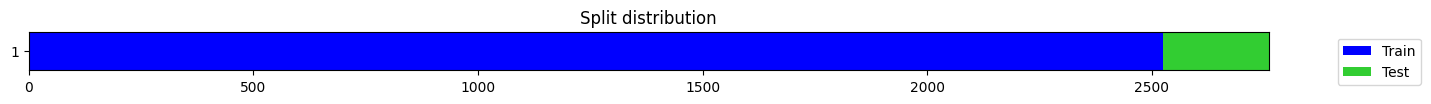

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,4539.636719,50.971386,7981.193848,74.748787,00:01


In [ ]:
ts = get_forecasting_time_series('Sunspots')
if ts is not None: # This is to prevent a test fail when the data server is not available
    X, y = SlidingWindowSplitter(60, horizon=1)(ts)
    X, y = X.astype('float32'), y.astype('float32')
    splits = TSSplitter(235)(y)
    batch_tfms = [TSStandardize(by_var=True)]
    learn = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=None, arch_config=dict(fc_dropout=.5), metrics=mae, bs=512,
                         partial_n=.1, train_metrics=True, device=default_device())
    learn.fit_one_cycle(1)

In [ ]:
X=torch.rand(8,2,50)
y=torch.rand(8,1)
splits = TimeSplitter(show_plot=False)(y)

fail_test = []
for arch in all_arch_names:
    if not "plus" in arch.lower(): continue
    try:
        fcst = TSForecaster(X, y, splits=splits, arch=arch, metrics=mse, device=default_device())
        with ContextManagers([fcst.no_bar(), fcst.no_logging()]):
            fcst.fit_one_cycle(1, 1e-3)
    except Exception as e:
        fail_test.append(arch)
        print(arch, e)

test_eq(fail_test, [])

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/022_tslearner.ipynb saved at 2025-01-22 18:45:21
Correct notebook to script conversion! 😃
Wednesday 22/01/25 18:45:24 CET
